<a href="https://colab.research.google.com/github/AkshitAggarwal/TSAI_EVA5B2_Phase1/blob/main/Session_06/S6_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy

In [2]:
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])
test_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                    ])

In [3]:
train_dataset = datasets.MNIST(root='./data', train = True, transform = train_transforms, download = True)
test_dataset = datasets.MNIST(root='./data', train = False, transform = test_transforms, download = True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu") #Assigns device based on availability

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#Arguments to be fed into dataloaders. 
dataloader_args = dict(shuffle=True, batch_size=100, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

##Train and Test dataloaders. 
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

In [5]:
class GBN(nn.Module):
  def __init__(self, num_features, groups, eps=1e-05):
    super(GBN, self).__init__()
    self.num_features = num_features
    self.eps = eps
    self.groups = groups

  def forward(self, X):
    """
    X: Input Tensor with (M, C, F) dimensions
    groupsM: Number of groups for the mini-batch dimension
    eps: A small value to prevent division by zero
    """
    # Split the mini-batch dimension into groups of smaller batches
    M, C, x, y = X.shape
    X = X.reshape(self.groups, -1, C, x, y)
    # Calculate statistics over dim(0) x dim(2) number
    # of slices of dim(1) x dim(3) dimension each
    mean = X.mean([1, 3], keepdim=True)
    var = X.var([1, 3], unbiased=False, keepdim=True)
    # Normalize X
    X = (X - mean) / (torch.sqrt(var + self.eps))
    # Reshape into the initial tensor shape
    X = X.reshape(M, C, x, y)
    return X

In [6]:
def convBlock(in_channels, out_channels, kernel_size, **kwargs):
    batch_normalize = nn.ModuleDict([
                       ['BN', nn.BatchNorm2d(out_channels)],
                       ['GBN', GBN(out_channels, 10)],
                       ['None', None]
                       ])
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, bias = False),
                         batch_normalize[kwargs['batch_norm']],
                         nn.ReLU(),
                         nn.Dropout(0.05)
                         )

In [7]:
class Net(nn.Module):
    #Constructor function initializes an object of Net() and defines all the layers. 
    #Each layer is defined here separately and aren't connected to each other in any way yet. 
    def __init__(self, **kwargs):
        super(Net, self).__init__()
        self.convBlock1 = convBlock(in_channels = 1, out_channels = 10, kernel_size = 3, **kwargs)
        self.convBlock2 = convBlock(in_channels = 10, out_channels = 10, kernel_size = 3, **kwargs)
        self.pool1 = nn.MaxPool2d(2, 2) #in_channel: 8,24,24; out_channel: 8,12,12; RF: 10
        self.convBlock3 = convBlock(in_channels = 10, out_channels = 10, kernel_size = 3, **kwargs)
        self.convBlock4 = convBlock(in_channels = 10, out_channels = 20, kernel_size = 3, **kwargs)
        self.convBlock5 = convBlock(in_channels = 20, out_channels = 20, kernel_size = 3, **kwargs)
        self.convBlock6 = convBlock(in_channels = 20, out_channels = 10, kernel_size = 3, **kwargs)
        self.gap = nn.AvgPool2d((4, 4)) #in_channel: 32,6,6; out_channel: 32,1,1; RF: ?
        self.convBlock7 = nn.Conv2d(10, 10, 1, bias = False) #in_channel: 20,1,1; out_channel: 10,1,1; 

    #Forward function takes an object and it passes through each layer sequentially. 
    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.pool1(x)
        x = self.convBlock3(x)
        x = self.convBlock4(x)
        x = self.convBlock5(x)
        x = self.convBlock6(x)
        x = self.gap(x)
        x = self.convBlock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim = -1)

In [8]:
!pip install torchsummary
from torchsummary import summary
model = Net(batch_norm = 'BN').to(device) #Converts our model into the respective device.
summary(model, input_size=(1, 28, 28)) #Prints the summary of our model based on an input size.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 10, 10, 10]             900
      BatchNorm2d-11           [-1, 10, 10, 10]              20
             ReLU-12           [-1, 10, 10, 10]               0
          Dropout-13           [-1, 10, 10, 10]               0
           Conv2d-14             [-1, 2

In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, L1):
  model.train()
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    #L1 Regularization
    if L1 is True:
        lambda_l1 = 0.0005
        l1 = 0
        for p in model.parameters():
            l1 += p.abs().sum()
        loss += lambda_l1 * l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    description = 'Loss={:.4f} Batch_id={} Accuracy={:.2f}'.format(loss.item(), batch_idx, 100*correct/processed)
    train_acc.append(100*correct/processed)
  print(description)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for d, t, p in zip(data, target, pred):
              if len(misclassified) < 25:
                if p != t:
                  misclassified.append((d, t, p))

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss, 100. * correct / len(test_loader.dataset), misclassified

In [10]:
def train_test_model(model, label, L1 = False, L2 = False, epochs = 25):
    #Picking the right optimizer based on L2 regularization
    if L2 is True:
        optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay = 0.001)
    else :
        optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    #Learning Rate schedular to adjust the LR based on model performance during training
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1)
    epoch_accuracies = []
    epoch_losses = []
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        print('Learning rate: ', optimizer.param_groups[0]['lr'])
        train(model, device, train_loader, optimizer, epoch, L1 = L1)
        loss, accuracy, misclassified = test(model, device, test_loader)
        scheduler.step(loss)
        epoch_accuracies.append(accuracy)
        epoch_losses.append(loss)
    return epoch_losses, epoch_accuracies, misclassified 

In [13]:
models =  [Net(batch_norm='BN').to(device),
           Net(batch_norm='BN').to(device),
           Net(batch_norm='BN').to(device),
           Net(batch_norm='GBN').to(device),
           Net(batch_norm='GBN').to(device),
           ]
labels = ['With L1 + BN',
          'With L2 + BN',
          'With L1 + L2 + BN',
          'With GBN',
          'With L1 + L2 + GBN',]
l1_vals = [True, False, True, False, True]
l2_vals = [False, True, True, False, True]
EPOCHS = 25

model_accuracies = [] #Accuracies over different models
model_losses = [] #Losses over different models
all_misclassified = []

for model, label, l1, l2 in zip(models, labels, l1_vals, l2_vals):
    print('============== Model: ', label, '===================')
    loss, accuracy, misclassified = train_test_model(model, label, L1 = l1, L2 = l2, epochs = EPOCHS)
    model_losses.append(loss)
    model_accuracies.append(accuracy)
    all_misclassified.append(misclassified)

============== Model:  With L1 + BN ===================
EPOCH: 0
Learning rate:  0.1
Loss=0.4712 Batch_id=599 Accuracy=92.24

Test set: Average loss: 0.1055, Accuracy: 9670/10000 (96.70%)

EPOCH: 1
Learning rate:  0.1
Loss=0.3551 Batch_id=599 Accuracy=96.27

Test set: Average loss: 0.1308, Accuracy: 9577/10000 (95.77%)

EPOCH: 2
Learning rate:  0.1
Loss=0.3064 Batch_id=599 Accuracy=96.51

Test set: Average loss: 0.1010, Accuracy: 9687/10000 (96.87%)

EPOCH: 3
Learning rate:  0.1
Loss=0.3338 Batch_id=599 Accuracy=96.53

Test set: Average loss: 0.1426, Accuracy: 9568/10000 (95.68%)

EPOCH: 4
Learning rate:  0.1
Loss=0.3356 Batch_id=599 Accuracy=96.48

Test set: Average loss: 0.1719, Accuracy: 9472/10000 (94.72%)

Epoch     5: reducing learning rate of group 0 to 1.0000e-02.
EPOCH: 5
Learning rate:  0.010000000000000002
Loss=0.2968 Batch_id=599 Accuracy=98.11

Test set: Average loss: 0.0347, Accuracy: 9901/10000 (99.01%)

EPOCH: 6
Learning rate:  0.010000000000000002
Loss=0.2812 Batch_id=

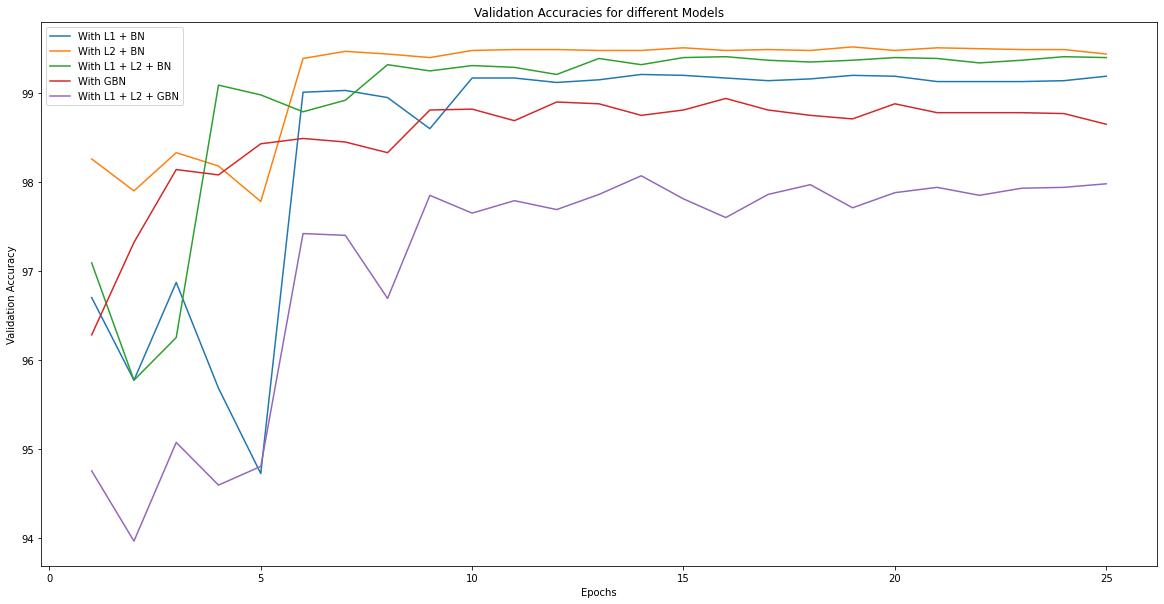

In [19]:
x = [t+1 for t in range(EPOCHS)]
plt.figure(figsize=(20,10))
for accuracy, label in zip(model_accuracies, labels):
  plt.plot(x, accuracy, label = label)
plt.xlabel('Epochs') #Sets label for X-axis
plt.ylabel('Validation Accuracy') #Sets label for Y-axis
plt.title('Validation Accuracies for different Models') #Sets label for the plot
plt.legend() #Shows the legend for the plot
plt.show()

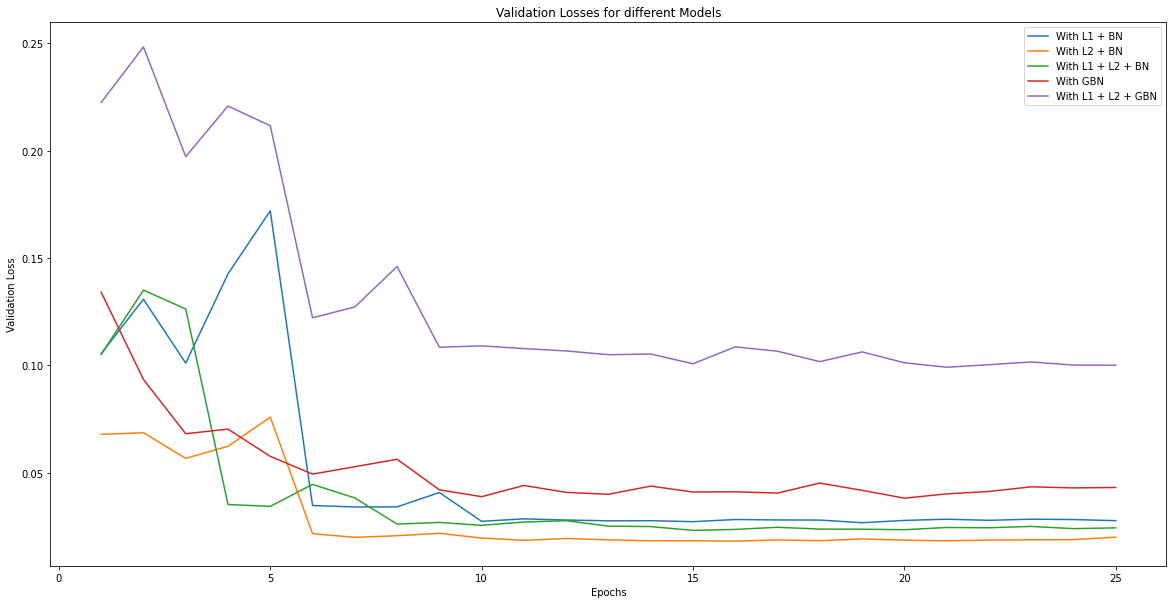

In [20]:
x = [t+1 for t in range(EPOCHS)]
plt.figure(figsize=(20,10))
for loss, label in zip(model_losses, labels):
  plt.plot(x, loss, label = label)
plt.xlabel('Epochs') #Sets label for X-axis
plt.ylabel('Validation Loss') #Sets label for Y-axis
plt.title('Validation Losses for different Models') #Sets label for the plot
plt.legend() #Shows the legend for the plot
plt.show()